In [1]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model


2025-01-21 16:37:21.370358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 16:37:21.377781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737506241.386692    6722 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737506241.389316    6722 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 16:37:21.398452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
image_path = '../temp/sentinel2_visual.tif'
model_path = '../models/2025-01-21_16-22-22.keras'
output_dir = '../output'
SIZE = 128
THRESHOLD = 0.4

/home/yifan/.local/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(np.float64(-0.5), np.float64(10979.5), np.float64(10979.5), np.float64(-0.5))

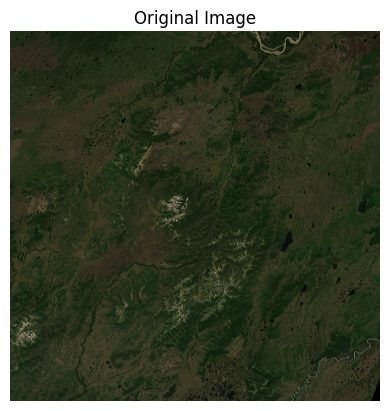

In [3]:
# Load and preprocess image
original_image = np.asarray(Image.open(image_path))
image = original_image.astype('float') / 255.

# Plot image
plt.figure()
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

In [4]:
h, w = image.shape[:2]

print(f"Image dimensions: {h} x {w}")

n_h = int(np.ceil(h / SIZE))
n_w = int(np.ceil(w / SIZE))

print(f"Number of tiles: {n_h} x {n_w}")

padded_h = n_h * SIZE
padded_w = n_w * SIZE

padded_image = np.zeros((padded_h, padded_w, 3))
padded_image[:h, :w, :] = image

print(f"Padded image dimensions: {padded_h} x {padded_w}")

tiles = []
positions = []
for i in range(n_h):
    for j in range(n_w):
        start_h = i * SIZE
        start_w = j * SIZE
        tile = padded_image[start_h:start_h + SIZE, start_w:start_w + SIZE].copy()
        tiles.append(tile)
        positions.append((start_h, start_w))


print(f"Created {len(tiles)} tiles")

Image dimensions: 10980 x 10980
Number of tiles: 86 x 86
Padded image dimensions: 11008 x 11008
Created 7396 tiles


In [5]:
model = load_model(model_path)
print(model.input_shape)

I0000 00:00:1737506248.259892    6722 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9508 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


(None, 128, 128, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


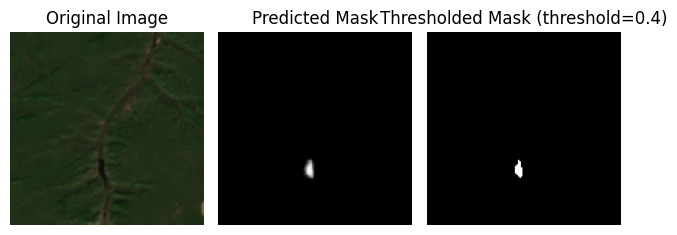

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


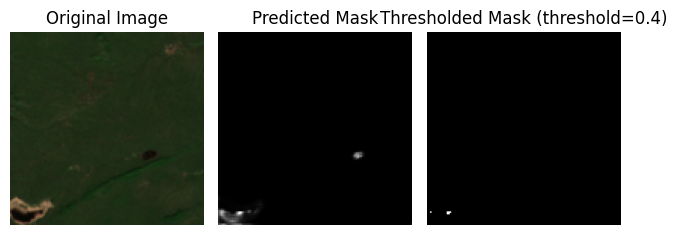

 20%|██        | 2/10 [00:00<00:00, 10.46it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


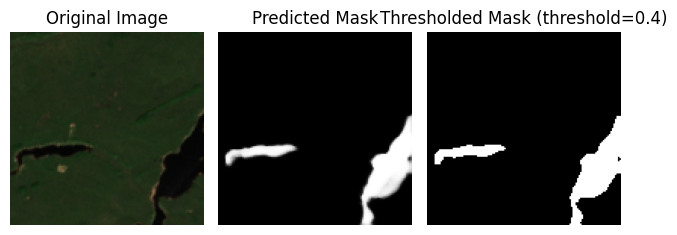

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


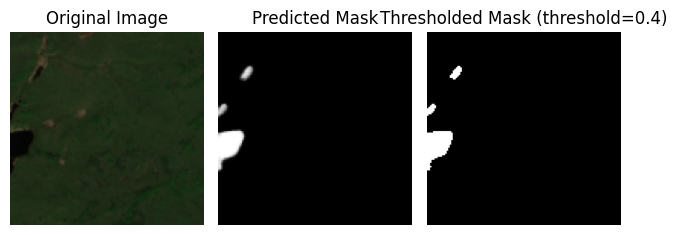

 40%|████      | 4/10 [00:00<00:00,  8.20it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


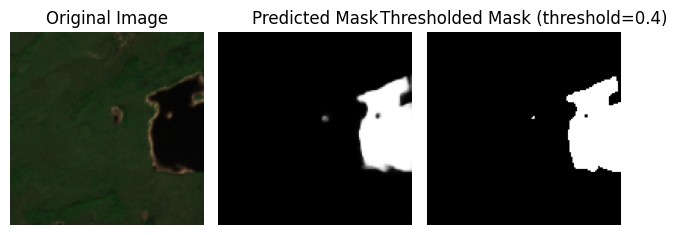

 50%|█████     | 5/10 [00:00<00:00,  8.66it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


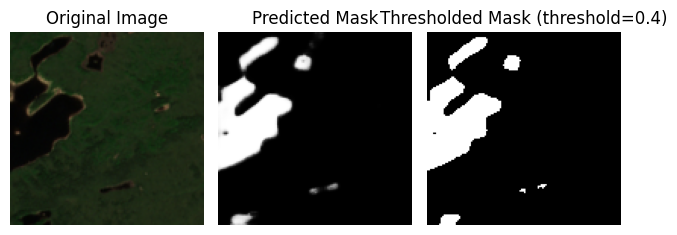

 60%|██████    | 6/10 [00:00<00:00,  8.51it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


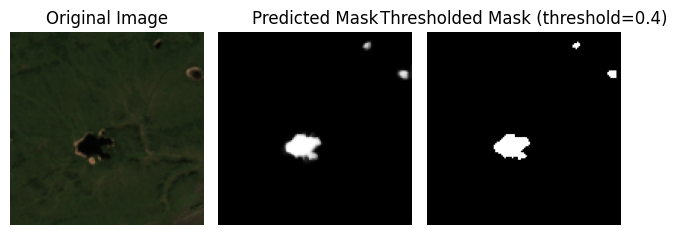

 70%|███████   | 7/10 [00:00<00:00,  8.90it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


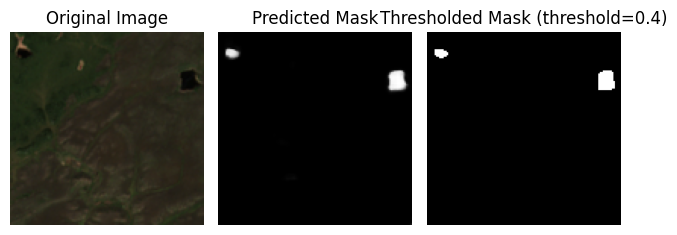

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


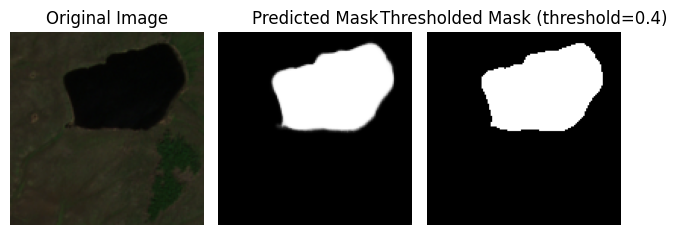

 90%|█████████ | 9/10 [00:00<00:00,  9.38it/s]

(128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 1)


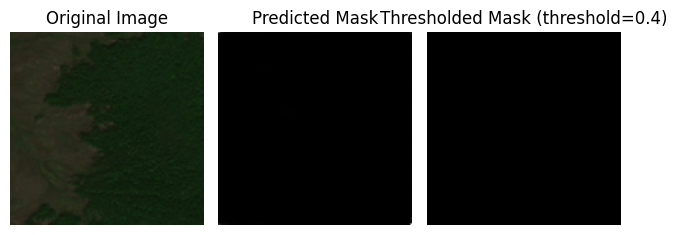

100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


In [8]:
predictions = []

for tile in tqdm(tiles[:10]):
    print(tile.shape)
    tile_batch = np.expand_dims(tile, axis=0)
    print(tile_batch.shape)
    pred = model.predict(tile_batch, verbose=0)
    print(pred.shape)
    predictions.append(pred[0])

    threshold_mask = pred[0] > THRESHOLD
    
    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(tile)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred[0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(threshold_mask, cmap='gray')
    plt.title(f'Thresholded Mask (threshold={THRESHOLD})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    